# EMRI Waveforms in Time and Frequency Domain

In this tutorial, we demonstrate how to use the Fast EMRI Waveform package to produce waveforms in the time domain (TD) as described in [arXiv 2104.04582](https://arxiv.org/abs/2104.04582) and in the frequency domain (FD) as described in [arXiv 2307.12585](https://arxiv.org/abs/2307.12585). We explore the representation of EMRI waveforms in both domains using a reference source. We compare the TD and FD waveforms using mismatch and estimate the waveform generation speed. Additionally, we explore the impact of spin and eccentricity on the waveform signal-to-noise ratio. Finally, we demonstrate mass invariance and downsampling using the Frequency Domain.

Created by Lorenzo Speri

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t, get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.interpolate import CubicSpline
from few import get_file_manager

# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1)
data[:, 1] = data[:, 1] ** 2
# define PSD function
get_sensitivity = CubicSpline(*data.T)


# define inner product eq 3 of https://www.nature.com/articles/s41550-022-01849-y
def inner_product(x, y, psd):
    return 4 * np.real(np.sum(np.conj(x) * y / psd))


# non uniform array of frequencies
def get_frequency_array(fmin, fmax, deltaf):
    p_freq = np.append(0.0, np.arange(fmin, fmax, step=deltaf))
    freq = np.hstack((-p_freq[::-1][:-1], p_freq))
    return freq

In [2]:
# Initialize waveform generators
# frequency domain
few_gen = GenerateEMRIWaveform(
    "FastKerrEccentricEquatorialFlux",
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=True,
)

# time domain
td_gen = GenerateEMRIWaveform(
    "FastKerrEccentricEquatorialFlux",
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=True,
)

In [3]:
# define the injection parameters
M = 0.5e6  # central object mass
a = 0.9  # will be ignored in Schwarzschild waveform
mu = 10.0  # secondary object mass
p0 = 12.0  # initial semi-latus rectum
e0 = 0.1  # eccentricity

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 3  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3

Tobs = 0.5  # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0  # time interval
eps = 1e-4  # mode content percentage

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": eps,
}

# get the initial p0 given a certain observation
p0 = get_p_at_t(
    traj_module,
    Tobs * 0.999,
    [M, mu, a, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)
print("New p0: ", p0)

emri_injection_params = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

New p0:  8.550316135032105


## Comparison against the Time Domain Waveforms

In [4]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# time the generation of the TD signal
start = time.time()
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)
end = time.time()
print("Time taken to generate the TD signal: ", end - start, "seconds")

# take the FFT of the plus polarization and shift it
fft_TD = np.fft.fftshift(np.fft.fft(data_channels_td[0])) * dt
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td[0]), dt))

# define the positive frequencies
positive_frequency_mask = freq >= 0.0

Time taken to generate the TD signal:  0.7932779788970947 seconds


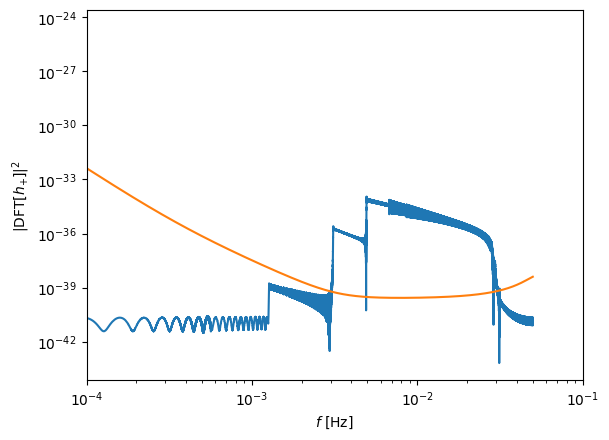

In [5]:
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask]) ** 2)
plt.loglog(
    freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask])
)
plt.ylabel(r"$| {\rm DFT} [h_{+}]|^2$")
plt.xlabel(r"$f$ [Hz]")
plt.xlim(1e-4, 1e-1)
plt.show()

In [6]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs["f_arr"] = freq  # get_frequency_array(1e-5, 1e-1, 1e-4)
fd_kwargs["mask_positive"] = True

# get FD waveform
hf = few_gen(*emri_injection_params, **fd_kwargs)
# time the generation of the FD signal
start = time.time()
hf = few_gen(*emri_injection_params, **fd_kwargs)
end = time.time()
print("Time taken to generate the FD signal: ", end - start, "seconds")
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mismatch
psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]
td_td = inner_product(
    fft_TD[positive_frequency_mask], fft_TD[positive_frequency_mask], psd
)
fd_fd = inner_product(hf[0], hf[0], psd)
Mism = np.abs(
    1
    - inner_product(fft_TD[positive_frequency_mask], hf[0], psd)
    / np.sqrt(td_td * fd_fd)
)
print("mismatch", Mism)
# SNR
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))

Time taken to generate the FD signal:  1.8117928504943848 seconds
mismatch 0.0003778551687809717
TD SNR 59.742245813394696
FD SNR 59.74220967463079


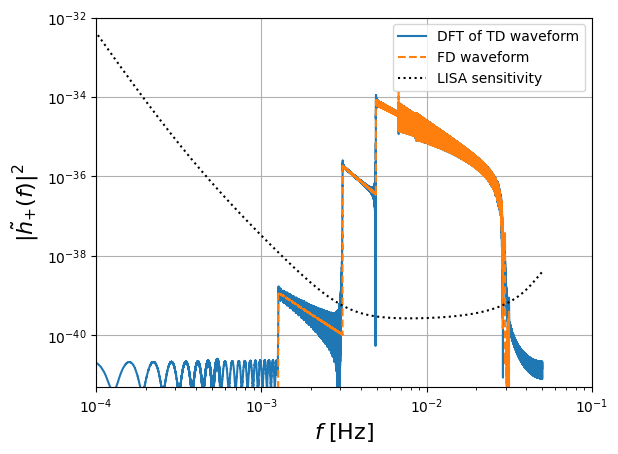

In [7]:
# FD plot
plt.figure()
plt.loglog(
    freq[positive_frequency_mask],
    np.abs(fft_TD[positive_frequency_mask]) ** 2,
    label="DFT of TD waveform",
)
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0]) ** 2, "--", label="FD waveform")
plt.loglog(
    freq[positive_frequency_mask],
    get_sensitivity(freq[positive_frequency_mask]),
    "k:",
    label="LISA sensitivity",
)
plt.ylabel(r"$| \tilde{h}_{+} (f)|^2$", fontsize=16)
plt.grid()
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend()
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
plt.show()
# plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

In [8]:
fd_kwargs_temp = waveform_kwargs.copy()
fd_kwargs_temp["f_arr"] = freq
# do not mask the positive frequencies
fd_kwargs_temp["mask_positive"] = False
hf_temp = few_gen(*emri_injection_params, **fd_kwargs_temp)

# check the consistency of the waveform
assert np.sum(hf_temp[0][positive_frequency_mask] - hf[0]) == 0.0

# define the hf to invert
hf_to_ifft = np.append(
    hf_temp[0][positive_frequency_mask], hf_temp[0][~positive_frequency_mask]
)

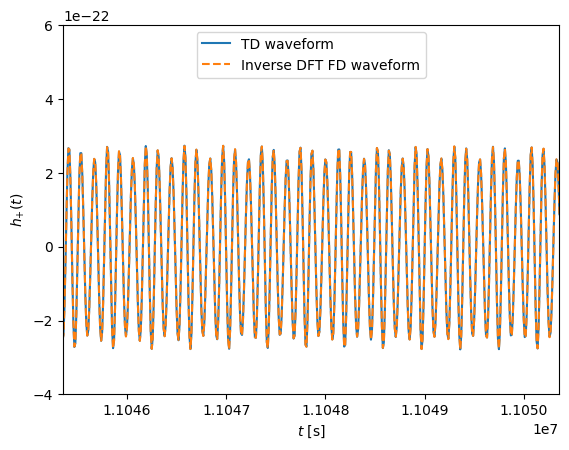

In [9]:
plt.figure()
# TD plot
time_array = np.arange(0, len(data_channels_td[0])) * dt
plt.plot(time_array, data_channels_td[0].real, label="TD waveform")
ifft_fd = np.fft.ifft(hf_to_ifft / dt)
plt.plot(time_array, ifft_fd.real, "--", label="Inverse DFT FD waveform")
plt.ylabel(r"$h_{+}(t)$")
plt.xlabel(r"$t$ [s]")

t0 = time_array[-1] * 0.7
space_t = 10e3
plt.xlim([t0, t0 + space_t / 2])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc="upper center")
plt.show()

In [10]:
from scipy.signal.windows import tukey

# no windowing
window = np.ones(len(data_channels_td[0]))  # np.asarray(hann(len(data_channels_td[0])))
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window)
fd_kwargs_nomask = fd_kwargs.copy()
del fd_kwargs_nomask["mask_positive"]
np.all(fd_gen(*emri_injection_params, **fd_kwargs_nomask)[0] == hf[0])

# add windowing
window = np.asarray(
    tukey(len(data_channels_td[0]), 0.01)
)  # np.asarray(data_channels_td[0]==0.0,dtype=float)#
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window)

hf = fd_gen(*emri_injection_params, **fd_kwargs_nomask)
fft_TD = fft_td_gen(*emri_injection_params, **fd_kwargs_nomask)

# mismatch
psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]
td_td = inner_product(fft_TD[0], fft_TD[0], psd)
fd_fd = inner_product(hf[0], hf[0], psd)
Mism = np.abs(1 - inner_product(fft_TD[0], hf[0], psd) / np.sqrt(td_td * fd_fd))
print("mismatch", Mism)
# SNR
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))

mismatch 0.00014514028732515172
TD SNR 59.53739187593751
FD SNR 59.552082838623235


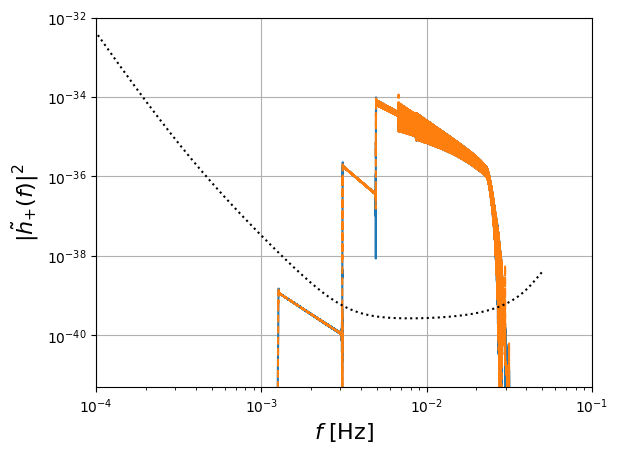

In [11]:
# FD plot
plt.figure()
plt.loglog(
    freq[positive_frequency_mask], np.abs(fft_TD[0]) ** 2, label="DFT of TD waveform"
)
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0]) ** 2, "--", label="FD waveform")
plt.loglog(
    freq[positive_frequency_mask],
    get_sensitivity(freq[positive_frequency_mask]),
    "k:",
    label="LISA sensitivity",
)
plt.ylabel(r"$| \tilde{h}_{+}(f)|^2$", fontsize=16)
plt.xlabel(r"$f$ [Hz]", fontsize=16)
# plt.legend(loc='upper left')
plt.grid()
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
plt.show()
# plt.savefig('figures/FD_TD_frequency_windowed.pdf', bbox_inches='tight')

/Users/c.chapman-bird@bham.ac.uk/miniconda3/envs/test_mpigou_few/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/c.chapman-bird@bham.ac.uk/miniconda3/envs/test_mpigou_few/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


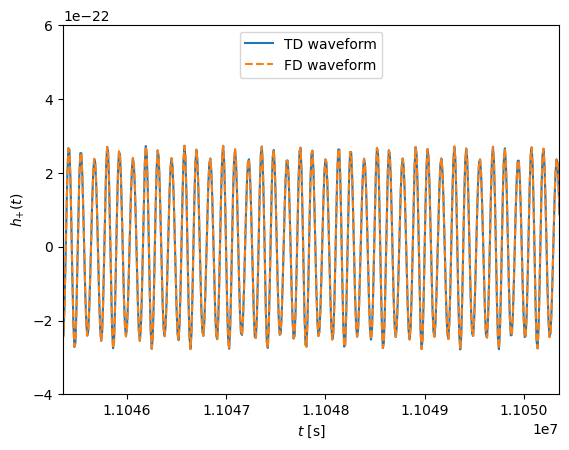

In [12]:
# TD plot
time_array = np.arange(0, len(data_channels_td[0])) * dt

plt.figure()

plt.plot(time_array, data_channels_td[0] * window, label="TD waveform")
plt.plot(time_array, ifft_fd, "--", label="FD waveform")
plt.ylabel(r"$h_{+}(t)$")
plt.xlabel(r"$t$ [s]")

t0 = time_array[-1] * 0.7
space_t = 10e3
plt.xlim([t0, t0 + space_t / 2])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc="upper center")
plt.show()

[-0.04999996 -0.0499999  -0.04999984 ...  0.04999984  0.0499999
  0.04999996]
Time taken to generate the FD signal:  1.5773627758026123 seconds
freq_fd (1574755,) h shape (1574755,)
TD SNR 59.53739187593751
FD SNR 59.552082838623235


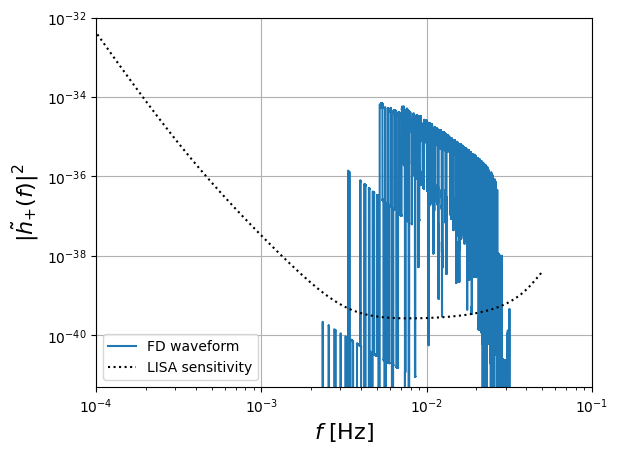

In [13]:
# you can specify the frequencies or obtain them directly from the waveform
freq_temp = get_frequency_array(1e-4, 5e-2, np.diff(freq)[0])

print(freq_temp)
fd_kwargs_red = waveform_kwargs.copy()
fd_kwargs_red["f_arr"] = freq_temp
fd_kwargs_red["mask_positive"] = False

# get FD waveform
hf = few_gen(*emri_injection_params, **fd_kwargs_red)
# time the generation of the FD signal
start = time.time()
hf = few_gen(*emri_injection_params, **fd_kwargs_red)
end = time.time()
print("Time taken to generate the FD signal: ", end - start, "seconds")
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency
# freq_temp = freq_temp[freq_temp>=0.0]
print("freq_fd", freq_fd.shape, "h shape", hf[0].shape)
# mismatch
# SNR
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))
# FD plot
plt.figure()
plt.loglog(freq_temp, np.abs(hf[0]) ** 2, "-", label="FD waveform")
plt.loglog(freq_temp, get_sensitivity(freq_temp), "k:", label="LISA sensitivity")
plt.ylabel(r"$| \tilde{h}_{+} (f)|^2$", fontsize=16)
plt.grid()
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc="lower left")
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
plt.show()
# plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

# Signal to noise ratio as a function of eccentricity and spin

In [14]:
def calculate_snr_mismatch(
    mode,
    emri_injection_params,
    waveform_kwargs,
    fd_kwargs,
    freq,
    positive_frequency_mask,
    dt,
):
    # Update fd_kwargs and td_kwargs with the current mode
    fd_kwargs = fd_kwargs.copy()
    fd_kwargs.pop("eps")
    fd_kwargs["mode_selection"] = [mode]
    hf_mode = few_gen(*emri_injection_params, **fd_kwargs)

    td_kwargs2 = waveform_kwargs.copy()
    td_kwargs2.pop("eps")
    td_kwargs2["mode_selection"] = [mode]
    data_channels_td_mode = td_gen(*emri_injection_params, **td_kwargs2)

    # Take the FFT of the plus polarization and shift it
    fft_TD_mode = np.fft.fftshift(np.fft.fft(data_channels_td_mode[0])) * dt

    # Calculate PSD
    psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]

    # Calculate inner products
    td_td = inner_product(
        fft_TD_mode[positive_frequency_mask], fft_TD_mode[positive_frequency_mask], psd
    )
    fd_fd = inner_product(hf_mode[0], hf_mode[0], psd)
    Mism = np.abs(
        1
        - inner_product(fft_TD_mode[positive_frequency_mask], hf_mode[0], psd)
        / np.sqrt(td_td * fd_fd)
    )

    # calculated frequency
    OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(
        emri_injection_params[2],
        emri_injection_params[3],
        emri_injection_params[4],
        emri_injection_params[5],
    )
    harmonic_frequency = (OmegaPhi * mode[1] + OmegaR * mode[2]) / (
        emri_injection_params[0] * MTSUN_SI * 2 * np.pi
    )
    return np.sqrt(td_td), Mism, harmonic_frequency


# Initialize data storage
data_out = []

# mode vector
eccentricity_vector = [0.1, 0.3, 0.7]
max_n_vector = [10, 18, 26]
spin_vector = [0.0, 0.9]

for a in spin_vector:
    for l_set, m_set in zip([2], [2]):
        temp = emri_injection_params.copy()
        for e_temp, max_n in zip(eccentricity_vector, max_n_vector):
            modes = [(l_set, m_set, ii) for ii in range(-3, max_n)]
            p_temp = get_p_at_t(
                traj_module,
                Tobs * 0.99,
                [M, mu, a, e_temp, 1.0],
                index_of_p=3,
                index_of_a=2,
                index_of_e=4,
                index_of_x=5,
                traj_kwargs={},
                xtol=2e-12,
                rtol=8.881784197001252e-16,
                bounds=None,
            )
            temp[3] = p_temp
            temp[4] = e_temp
            temp[2] = a
            out = np.asarray(
                [
                    calculate_snr_mismatch(
                        mode,
                        temp,
                        waveform_kwargs,
                        fd_kwargs,
                        freq,
                        positive_frequency_mask,
                        dt,
                    )
                    for mode in modes
                ]
            )
            snr, Mism, harmonic_frequency = out.T
            data_out.append((harmonic_frequency, snr, l_set, m_set, e_temp, a))

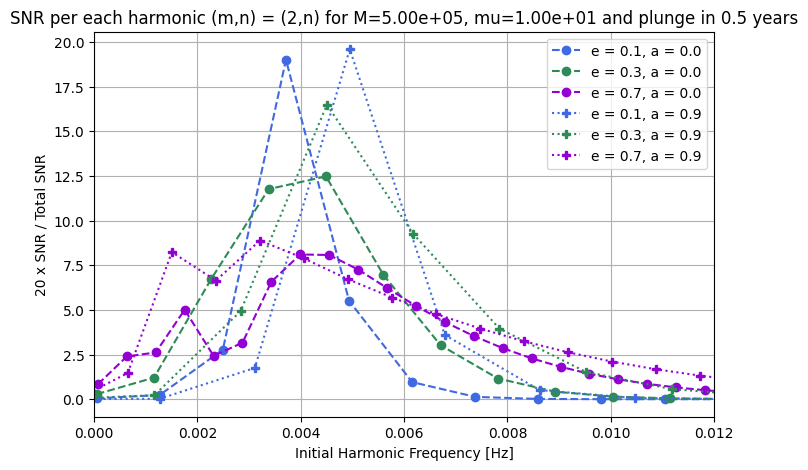

In [15]:
# Plot the data
colors = {0.1: "royalblue", 0.3: "seagreen", 0.5: "crimson", 0.7: "darkviolet"}

plt.figure(figsize=(8, 5))
for harmonic_frequency, snr, l_set, m_set, e_temp, a in data_out:
    color = colors[e_temp]
    if a == 0.9:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            ":P",
            label=f"e = {e_temp}, a = {a}",
            color=color,
        )
        # plt.text(harmonic_frequency[-1], 20.0 * snr[-1]/np.sum(snr**2)**0.5, f"({l_set},{m_set})", fontsize=8)
    if a == 0.0:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            "--o",
            label=f"e = {e_temp}, a = {a}",
            color=color,
        )
        # for ii in range(len(harmonic_frequency)):
        #     plt.text(harmonic_frequency[ii], 20.0 * snr[ii]/np.sum(snr**2)**0.5, f"n={ii-3}", fontsize=8)

plt.xlabel("Initial Harmonic Frequency [Hz]")
plt.ylabel("20 x SNR / Total SNR")
plt.title(
    f"SNR per each harmonic (m,n) = ({2},n) for M={M:.2e}, mu={mu:.2e} and plunge in {Tobs} years"
)
plt.xlim(0, 0.012)
plt.grid()
plt.legend()
plt.show()

In [16]:
# Initialize data storage
data_out = []

# mode vector
a = 0.0
Tobs = 0.1  # observation time, if the inspiral is shorter, the it will be zero padded
eccentricity_vector = [0.1, 0.5]
max_n_vector = [10, 26]
eta_vector = [1e-4, 1e-6]  # mass ratio values

for eta in eta_vector:
    for e_temp, max_n in zip(eccentricity_vector, max_n_vector):
        temp = emri_injection_params.copy()
        mu = eta * M
        p_temp = get_p_at_t(
            traj_module,
            Tobs * 0.99,
            [M, mu, a, e_temp, 1.0],
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-6,
            rtol=8.881784197001252e-6,
        )
        temp[3] = p_temp
        temp[4] = e_temp
        temp[1] = mu
        for l_set, m_set in zip([2], [2]):
            modes = [(l_set, m_set, ii) for ii in range(-3, max_n)]
            out = np.asarray(
                [
                    calculate_snr_mismatch(
                        mode,
                        temp,
                        waveform_kwargs,
                        fd_kwargs,
                        freq,
                        positive_frequency_mask,
                        dt,
                    )
                    for mode in modes
                ]
            )
            snr, Mism, harmonic_frequency = out.T
            data_out.append((harmonic_frequency, snr, l_set, m_set, e_temp, eta))

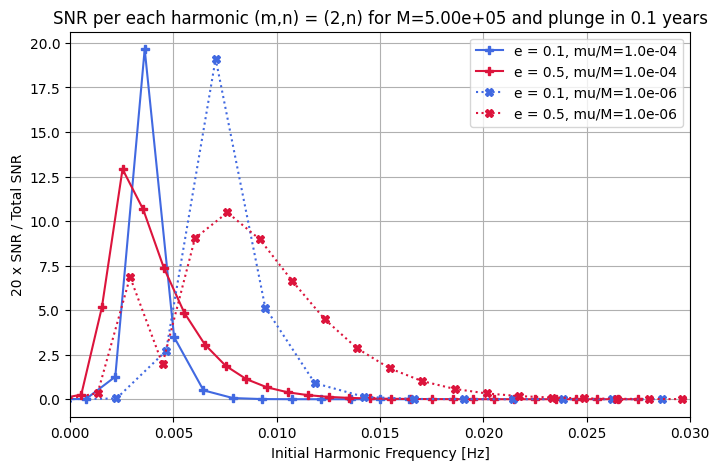

In [17]:
# Plot the data
colors = {0.1: "royalblue", 0.3: "seagreen", 0.5: "crimson", 0.7: "darkviolet"}

plt.figure(figsize=(8, 5))
for harmonic_frequency, snr, l_set, m_set, e_temp, eta_temp in data_out:
    color = colors[e_temp]
    if eta_temp == 1e-4:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            "-P",
            label=f"e = {e_temp}, mu/M={eta_temp:.1e}",
            color=color,
        )
    if eta_temp == 1e-6:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            ":X",
            label=f"e = {e_temp}, mu/M={eta_temp:.1e}",
            color=color,
        )

plt.xlabel("Initial Harmonic Frequency [Hz]")
plt.ylabel("20 x SNR / Total SNR")
plt.title(
    f"SNR per each harmonic (m,n) = ({2},n) for M={M:.2e} and plunge in {Tobs} years"
)
plt.xlim(0, 0.03)
plt.grid()
plt.legend()
plt.show()

## Speed test as a function of the parameter space

In [18]:
# create a function that times the FD and TD waveform generation for different input parameters


def time_waveform_generation(fd_waveform_func, td_waveform_func, input_params, kwargs):
    """
    Times the FD and TD waveform generation for different input parameters.

    Parameters:
    fd_waveform_func (function): Function to generate FD waveform.
    td_waveform_func (function): Function to generate TD waveform.
    input_params (list): List of dictionaries containing input parameters for the waveform functions.

    Returns:
    list: List of dictionaries containing input parameters and their corresponding FD and TD generation times.
    """
    results = []

    for params in input_params:
        # Time FD waveform generation
        start_time = time.time()
        fd_waveform_func(*params, **kwargs)
        fd_time = time.time() - start_time

        # Time TD waveform generation
        start_time = time.time()
        td_waveform_func(*params, **kwargs)
        td_time = time.time() - start_time

        # Store the results
        result = {"input_params": params, "fd_time": fd_time, "td_time": td_time}
        results.append(result)

    return results


timing_results = []
vec_par = []
Tobs = 2.0
# create a list of input parameters for M, mu, a, p0, e0, x0
for el in np.linspace(0.1, 0.7, num=5):
    # Tobs = np.random.uniform(0.1, 0.9)
    temp = emri_injection_params.copy()
    temp[4] = el
    temp[3] = get_p_at_t(
        traj_module,
        Tobs * 0.99,
        [M, mu, a, temp[4], 1.0],
        index_of_p=3,
        index_of_a=2,
        index_of_e=4,
        index_of_x=5,
        traj_kwargs={},
        xtol=2e-6,
        rtol=8.881784197001252e-6,
    )
    vec_par.append(temp.copy())


waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": eps,
}
timing_results = time_waveform_generation(few_gen, td_gen, vec_par, waveform_kwargs)

print(timing_results)

[{'input_params': [500000.0, 10.0, 0.9, 8.352141540779131, 0.1, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 6.0655529499053955, 'td_time': 0.8256080150604248}, {'input_params': [500000.0, 10.0, 0.9, 8.428812570017591, 0.25, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 8.64582896232605, 'td_time': 0.9522151947021484}, {'input_params': [500000.0, 10.0, 0.9, 8.53177902890358, 0.4, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 13.303467988967896, 'td_time': 1.182814121246338}, {'input_params': [500000.0, 10.0, 0.9, 8.633756599048972, 0.5499999999999999, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'f

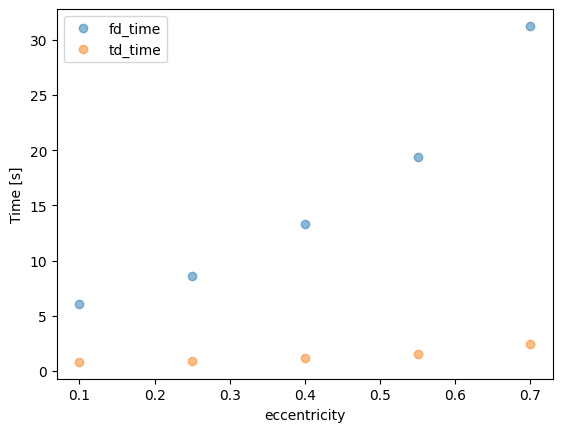

In [19]:
for lab in ["fd_time", "td_time"]:
    timing = [el[lab] for el in timing_results]
    ecc = [el["input_params"][4] for el in timing_results]
    plt.plot(ecc, timing, "o", label=lab, alpha=0.5)
plt.xlabel("eccentricity")
plt.ylabel("Time [s]")
plt.legend()
plt.show()

## Mass invariance
If we fix the mass ratio of an EMRI system the frequency domain waveform is invariant under a total mass change as long as we consider dimensionless frequencies. We show this here as a check of our frequency domain implementation.

In [20]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
# array of total masses
Mvec = 10 ** np.linspace(5.0, 6.5, num=3)

for M in Mvec:
    # fix mass ratio
    mu = 5e-5 * M

    # rescale time
    Tnew = T * (M / 1e6)

    # generate wave
    list_h.append(
        few_gen(
            M,
            mu,
            a,
            p0,
            e0,
            x0,
            dist,
            qS,
            phiS,
            qK,
            phiK,
            Phi_phi0,
            Phi_theta0,
            Phi_r0,
            T=10.0,
            dt=dt,
            mode_selection=[(2, 2, 0)],
            mask_positive=True,
        )
    )

    # dimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI)

/Users/c.chapman-bird@bham.ac.uk/miniconda3/envs/test_mpigou_few/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


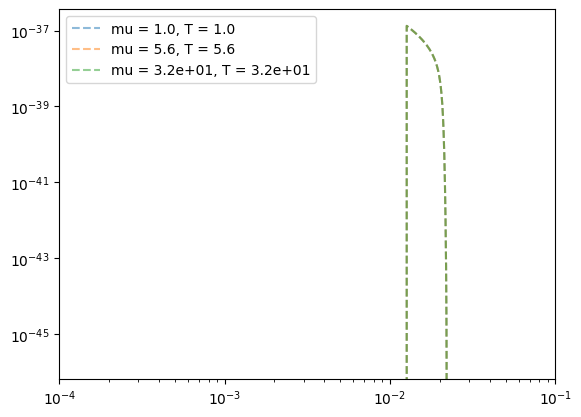

In [21]:
plt.figure()
for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]

    ff = list_f[ii]
    ff = ff[ff >= 0.0]
    h2 = np.abs(list_h[ii][0] / (tmp_mu * Tnew)) ** 2
    plt.loglog(ff, h2, "--", label=f"mu = {tmp_mu:.2}, T = {Tnew:.2}", alpha=0.5)

plt.xlim([1e-4, 1e-1])
plt.legend()
plt.show()

## Downsampled FD Waveforms
One of the main advantages of the frequency domain formulation is that we can downsample the frequencies to reduce the computational cost of the waveform. This is illustrated in the following cells where we perform different levels of downsampling.

In [22]:
M, mu, p0, e0 = (
    3670041.7362535275,
    292.0583167470244,
    13.709101864726545,
    0.5794130830706371,
)  # 1e6, 10.0, 13.709101864726545, 0.5794130830706371 #

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 3  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3

Tobs = 4.0  # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0  # time interval
eps = 1e-2  # mode content percentage
mode_selection = [(2, 2, 0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    # you can uncomment the following ling if you want to show a mode
    #     "mode_selection" : mode_selection,
    #     "include_minus_m": True
    "eps": eps,
}

# get the initial p0
p0 = get_p_at_t(
    traj_module,
    Tobs * 0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

max frequency 0.002815809639046519
max frequency 0.002815809639046519


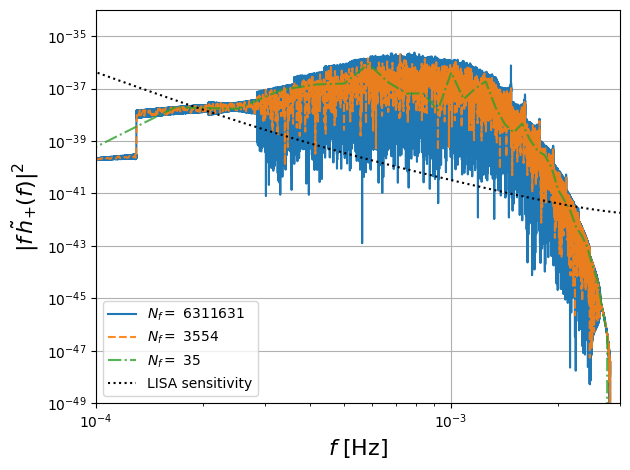

In [23]:
# FD plot
plt.figure()

alpha = [1.0, 0.9, 0.8, 0.2]
linest = ["-", "--", "-.", ":"]

for upp, aa, ls in zip([1, 100, 10000], alpha, linest):
    # you can specify the frequencies or obtain them directly from the waveform
    fd_kwargs = waveform_kwargs.copy()
    fd_kwargs["mask_positive"] = True
    # get FD waveform
    hf = few_gen(*emri_injection_params, **fd_kwargs)
    freq_fd = few_gen.waveform_generator.create_waveform.frequency
    positive_frequency_mask = freq_fd >= 0.0
    mask_non_zero = hf[0] != complex(0.0)
    end_f = few_gen.waveform_generator.create_waveform.frequency[
        positive_frequency_mask
    ][mask_non_zero].max()

    if upp != 1:
        num = int(len(freq_fd[positive_frequency_mask][mask_non_zero]) / upp)
        p_freq = np.linspace(0.0, end_f * 1.01, num=num)
        print("max frequency", end_f)
        newfreq = np.hstack((-p_freq[::-1][:-1], p_freq))

        # you can specify the frequencies or obtain them directly from the waveform
        fd_kwargs = waveform_kwargs.copy()
        fd_kwargs["f_arr"] = newfreq
        fd_kwargs["mask_positive"] = True

        # get FD waveform
        hf = few_gen(*emri_injection_params, **fd_kwargs)
        # to get the frequencies:
        freq_fd = few_gen.waveform_generator.create_waveform.frequency
        positive_frequency_mask = freq_fd >= 0.0

    Nf = len(freq_fd[positive_frequency_mask])
    plt.loglog(
        freq_fd[positive_frequency_mask],
        freq_fd[positive_frequency_mask] ** 2 * np.abs(hf[0]) ** 2,
        ls,
        label=f"$N_f = $ {Nf}",
        alpha=aa,
    )


ff = 10 ** np.linspace(-5, -1, num=100)
plt.loglog(ff, ff * get_sensitivity(ff), "k:", label="LISA sensitivity")

plt.ylabel(r"$|f\, \tilde{h}_{+}(f)|^2$", fontsize=16)
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc="lower left")
plt.xlim(1e-4, 3e-3)
plt.grid()
plt.ylim([1e-49, 1e-34])
plt.tight_layout()
plt.show()

# plt.savefig('figures/spectrum_downsampled.pdf')